# Classical Time Series Models: ETS and STL Decomposition

This notebook demonstrates classical time series forecasting methods including:
- Exponential Smoothing (ETS) models
- Seasonal and Trend decomposition using Loess (STL)
- Model comparison and selection criteria
- Practical applications with real-world patterns

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/examples does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from typing import Tuple, Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Introduction to Classical Time Series Forecasting

Classical time series models decompose a series into components:

### Time Series Components

1. **Level (L)**: The average value in the series
2. **Trend (T)**: The long-term increase or decrease
3. **Seasonality (S)**: Repeating patterns at fixed intervals
4. **Remainder (R)**: Random fluctuation (noise)

### Decomposition Types

**Additive**: $Y_t = L_t + T_t + S_t + R_t$
- Use when seasonal variation is constant over time
- Seasonal fluctuations have same magnitude regardless of level

**Multiplicative**: $Y_t = L_t \times T_t \times S_t \times R_t$
- Use when seasonal variation changes with level
- Seasonal fluctuations proportional to the level

### Key Methods

1. **Exponential Smoothing (ETS)**: State space models with error, trend, seasonality
2. **STL Decomposition**: Robust decomposition using LOESS smoothing
3. **ARIMA**: Autoregressive Integrated Moving Average models

## Generate Synthetic Time Series Data

Create datasets with known patterns for demonstration

In [3]:
def generate_time_series(
    n_periods: int = 365,
    freq: str = 'D',
    level: float = 100.0,
    trend: float = 0.1,
    seasonal_periods: List[int] = [7],
    seasonal_magnitude: List[float] = [10.0],
    noise_std: float = 5.0,
    multiplicative: bool = False
) -> pd.DataFrame:
    """
    Generate synthetic time series with configurable components.
    
    Parameters
    ----------
    n_periods : int
        Number of time periods
    freq : str
        Frequency string (D, H, M, etc.)
    level : float
        Base level of the series
    trend : float
        Linear trend coefficient
    seasonal_periods : List[int]
        List of seasonal periods (e.g., [7, 365] for weekly and yearly)
    seasonal_magnitude : List[float]
        Magnitude of each seasonal component
    noise_std : float
        Standard deviation of random noise
    multiplicative : bool
        If True, use multiplicative seasonality
    
    Returns
    -------
    pd.DataFrame
        DataFrame with date index and value column
    """
    # Create date range
    dates = pd.date_range(start='2022-01-01', periods=n_periods, freq=freq)
    
    # Base level and trend
    t = np.arange(n_periods)
    level_trend = level + trend * t
    
    # Add seasonal components
    seasonal = np.zeros(n_periods)
    for period, magnitude in zip(seasonal_periods, seasonal_magnitude):
        seasonal += magnitude * np.sin(2 * np.pi * t / period)
    
    # Add noise
    noise = np.random.normal(0, noise_std, n_periods)
    
    # Combine components
    if multiplicative:
        seasonal_factor = 1 + seasonal / 100  # Convert to percentage
        values = level_trend * seasonal_factor + noise
    else:
        values = level_trend + seasonal + noise
    
    # Ensure non-negative values
    values = np.maximum(values, 0.1)
    
    df = pd.DataFrame({
        'date': dates,
        'value': values
    })
    
    return df.set_index('date')

In [4]:
# Generate different types of time series

# 1. Simple series with weekly seasonality (additive)
ts_weekly_additive = generate_time_series(
    n_periods=365,
    level=100,
    trend=0.2,
    seasonal_periods=[7],
    seasonal_magnitude=[15],
    noise_std=5,
    multiplicative=False
)

# 2. Series with monthly seasonality (multiplicative)
ts_monthly_mult = generate_time_series(
    n_periods=365,
    level=200,
    trend=0.5,
    seasonal_periods=[30],
    seasonal_magnitude=[20],
    noise_std=8,
    multiplicative=True
)

# 3. Complex series with multiple seasonalities
ts_multiple = generate_time_series(
    n_periods=730,  # 2 years
    level=150,
    trend=0.3,
    seasonal_periods=[7, 365],  # Weekly and yearly
    seasonal_magnitude=[10, 25],
    noise_std=6,
    multiplicative=False
)

# 4. Series without trend (for simple exponential smoothing)
ts_no_trend = generate_time_series(
    n_periods=200,
    level=100,
    trend=0.0,
    seasonal_periods=[7],
    seasonal_magnitude=[0],  # No seasonality
    noise_std=10,
    multiplicative=False
)

print("Generated time series:")
print(f"- Weekly additive: {len(ts_weekly_additive)} observations")
print(f"- Monthly multiplicative: {len(ts_monthly_mult)} observations")
print(f"- Multiple seasonalities: {len(ts_multiple)} observations")
print(f"- No trend: {len(ts_no_trend)} observations")

Generated time series:
- Weekly additive: 365 observations
- Monthly multiplicative: 365 observations
- Multiple seasonalities: 730 observations
- No trend: 200 observations


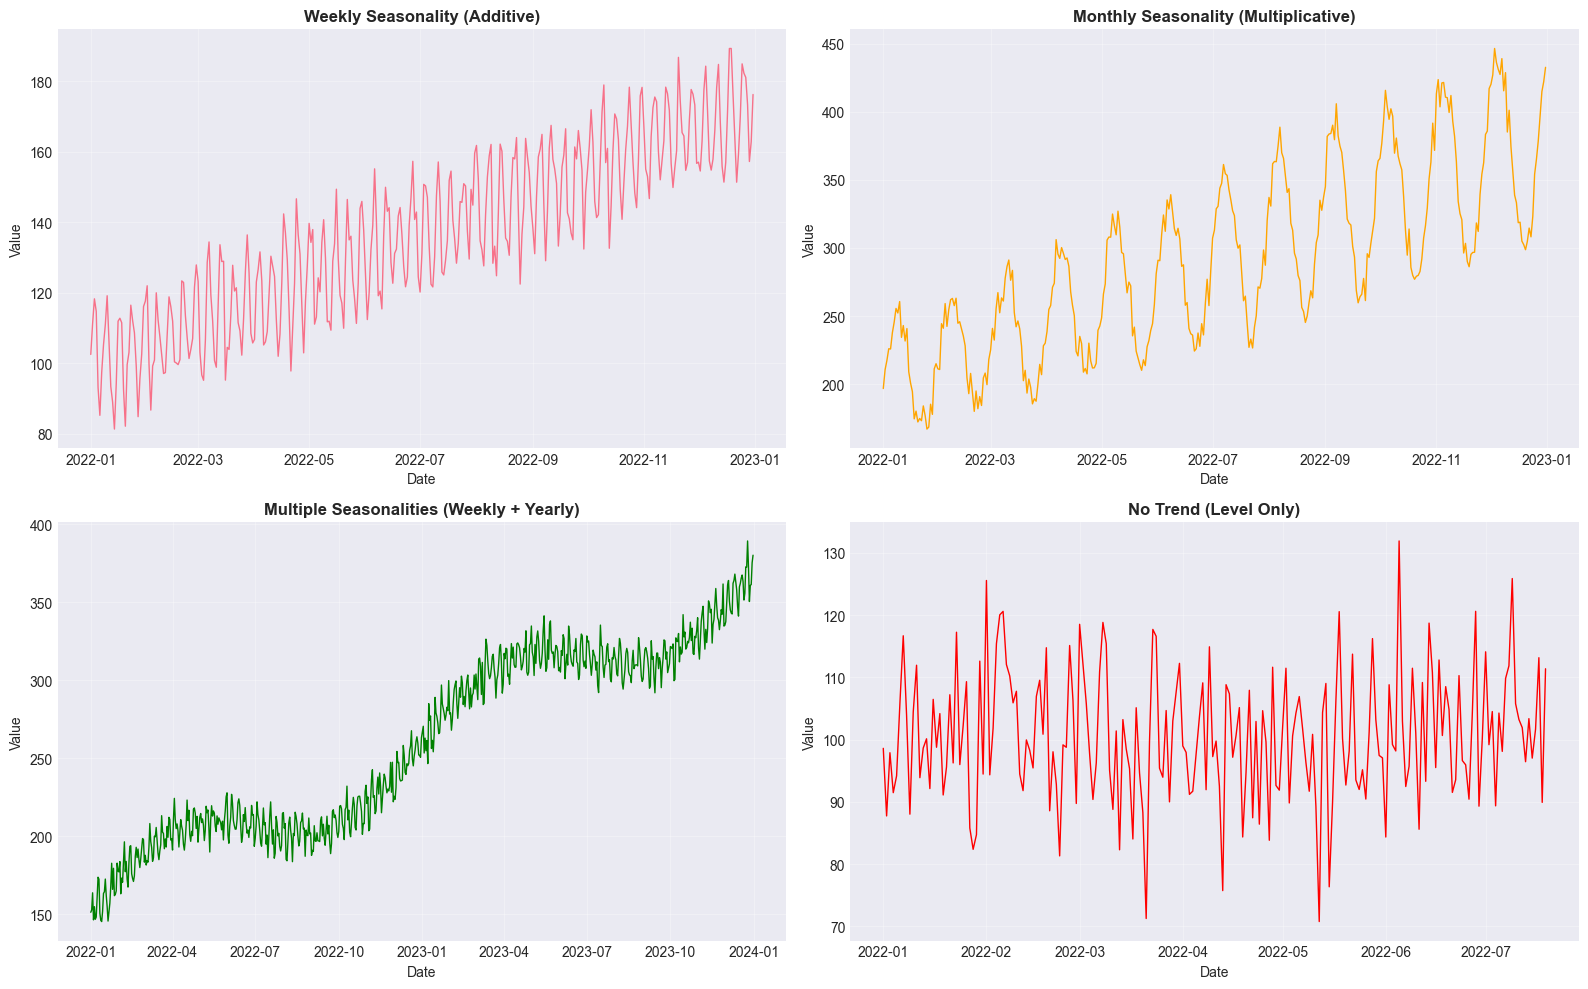

In [5]:
# Visualize the generated series
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Weekly additive
axes[0, 0].plot(ts_weekly_additive.index, ts_weekly_additive['value'], linewidth=1)
axes[0, 0].set_title('Weekly Seasonality (Additive)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Monthly multiplicative
axes[0, 1].plot(ts_monthly_mult.index, ts_monthly_mult['value'], linewidth=1, color='orange')
axes[0, 1].set_title('Monthly Seasonality (Multiplicative)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Value')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Multiple seasonalities
axes[1, 0].plot(ts_multiple.index, ts_multiple['value'], linewidth=1, color='green')
axes[1, 0].set_title('Multiple Seasonalities (Weekly + Yearly)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Value')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: No trend
axes[1, 1].plot(ts_no_trend.index, ts_no_trend['value'], linewidth=1, color='red')
axes[1, 1].set_title('No Trend (Level Only)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Value')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Exponential Smoothing Methods (ETS)

Exponential smoothing methods use weighted averages of past observations, with weights decaying exponentially.

### ETS Framework

**ETS(Error, Trend, Seasonal)**

- **Error**: {A=Additive, M=Multiplicative}
- **Trend**: {N=None, A=Additive, Ad=Additive damped}
- **Seasonal**: {N=None, A=Additive, M=Multiplicative}

### Smoothing Parameters

- **α (alpha)**: Level smoothing parameter [0, 1]
  - Higher α: more weight on recent observations
  - Lower α: smoother, more weight on historical data

- **β (beta)**: Trend smoothing parameter [0, 1]
  - Controls how quickly trend estimates change

- **γ (gamma)**: Seasonal smoothing parameter [0, 1]
  - Controls how quickly seasonal pattern changes

- **φ (phi)**: Damping parameter [0, 1]
  - Applied to trend component
  - Prevents trend from continuing indefinitely

### 2.1 Simple Exponential Smoothing (SES)

**Model**: ETS(A,N,N)

For series with no clear trend or seasonality. Only models the level.

**Equation**: $\hat{y}_{t+1} = \alpha y_t + (1-\alpha) \hat{y}_t$

Where:
- $\hat{y}_{t+1}$ is the forecast for time t+1
- $\alpha$ is the smoothing parameter
- $y_t$ is the actual value at time t

In [6]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Apply Simple Exponential Smoothing to no-trend series
# Split into train/test
train_size = int(len(ts_no_trend) * 0.8)
train_no_trend = ts_no_trend.iloc[:train_size]
test_no_trend = ts_no_trend.iloc[train_size:]

# Fit models with different alpha values
alpha_values = [0.1, 0.3, 0.7]
ses_models = {}
ses_forecasts = {}

for alpha in alpha_values:
    model = SimpleExpSmoothing(train_no_trend['value'])
    fitted = model.fit(smoothing_level=alpha, optimized=False)
    ses_models[alpha] = fitted
    ses_forecasts[alpha] = fitted.forecast(steps=len(test_no_trend))

# Also fit with optimized alpha
model_auto = SimpleExpSmoothing(train_no_trend['value'])
fitted_auto = model_auto.fit()
ses_models['auto'] = fitted_auto
ses_forecasts['auto'] = fitted_auto.forecast(steps=len(test_no_trend))

print("Simple Exponential Smoothing Results:")
print(f"Optimized alpha: {fitted_auto.params['smoothing_level']:.4f}")
print(f"AIC: {fitted_auto.aic:.2f}")

Simple Exponential Smoothing Results:
Optimized alpha: 0.0055
AIC: 758.68


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: Val

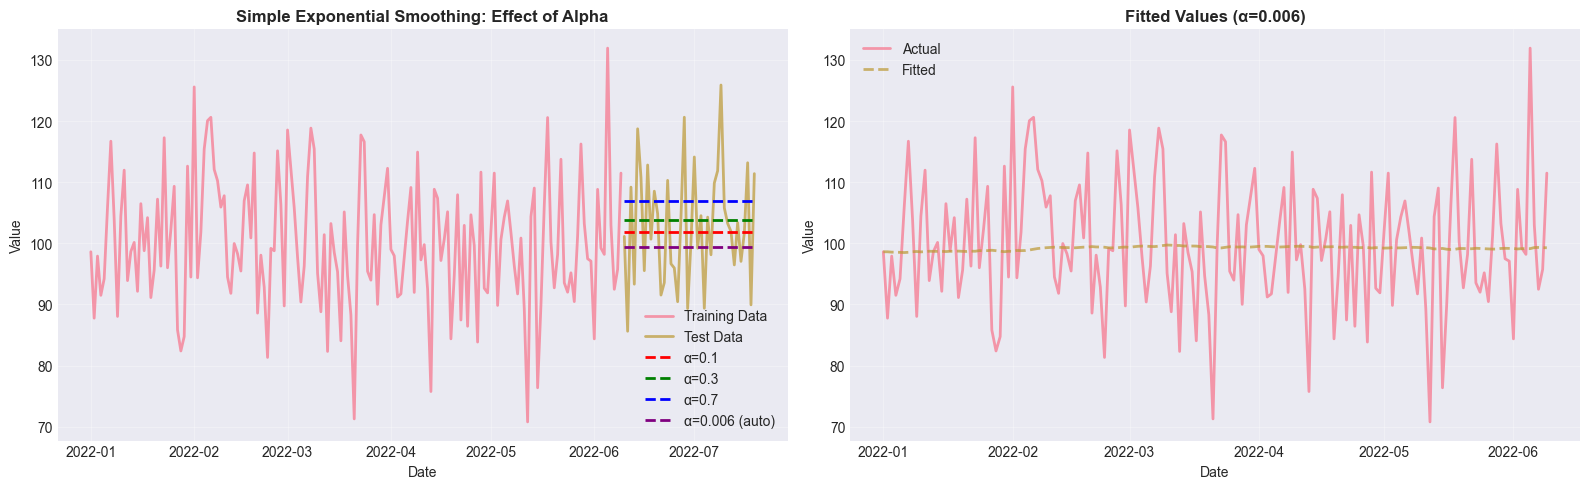

In [7]:
# Visualize SES with different alpha values
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Left: Compare different alpha values
axes[0].plot(train_no_trend.index, train_no_trend['value'], 
             label='Training Data', linewidth=2, alpha=0.7)
axes[0].plot(test_no_trend.index, test_no_trend['value'], 
             label='Test Data', linewidth=2, alpha=0.7)

colors = ['red', 'green', 'blue', 'purple']
for (alpha, forecast), color in zip(ses_forecasts.items(), colors):
    label = f'α={alpha:.1f}' if alpha != 'auto' else f'α={fitted_auto.params["smoothing_level"]:.3f} (auto)'
    axes[0].plot(test_no_trend.index, forecast, 
                 label=label, linewidth=2, linestyle='--', color=color)

axes[0].set_title('Simple Exponential Smoothing: Effect of Alpha', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Fitted values vs actual (using auto alpha)
fitted_values = fitted_auto.fittedvalues
axes[1].plot(train_no_trend.index, train_no_trend['value'], 
             label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(train_no_trend.index, fitted_values, 
             label='Fitted', linewidth=2, linestyle='--', alpha=0.7)
axes[1].set_title(f'Fitted Values (α={fitted_auto.params["smoothing_level"]:.3f})', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 Holt's Linear Trend Method

**Model**: ETS(A,A,N)

Extension of SES that adds a trend component.

**Equations**:
- Level: $l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$
- Forecast: $\hat{y}_{t+h} = l_t + h \cdot b_t$

**Damped Trend**: ETS(A,Ad,N)
- Forecast: $\hat{y}_{t+h} = l_t + (\phi + \phi^2 + ... + \phi^h) \cdot b_t$
- Prevents trend from continuing indefinitely

In [8]:
from statsmodels.tsa.holtwinters import Holt

# Use weekly additive series (has trend)
train_size = int(len(ts_weekly_additive) * 0.8)
train_weekly = ts_weekly_additive.iloc[:train_size]
test_weekly = ts_weekly_additive.iloc[train_size:]

# Fit Holt's linear trend model
holt_linear = Holt(train_weekly['value'])
fitted_linear = holt_linear.fit()

# Fit Holt's damped trend model
holt_damped = Holt(train_weekly['value'], damped_trend=True)
fitted_damped = holt_damped.fit()

# Generate forecasts
forecast_linear = fitted_linear.forecast(steps=len(test_weekly))
forecast_damped = fitted_damped.forecast(steps=len(test_weekly))

print("Holt's Linear Trend Method:")
print(f"  α (level): {fitted_linear.params['smoothing_level']:.4f}")
print(f"  β (trend): {fitted_linear.params['smoothing_trend']:.4f}")
print(f"  AIC: {fitted_linear.aic:.2f}")
print(f"  BIC: {fitted_linear.bic:.2f}")

print("\nHolt's Damped Trend Method:")
print(f"  α (level): {fitted_damped.params['smoothing_level']:.4f}")
print(f"  β (trend): {fitted_damped.params['smoothing_trend']:.4f}")
print(f"  φ (damping): {fitted_damped.params['damping_trend']:.4f}")
print(f"  AIC: {fitted_damped.aic:.2f}")
print(f"  BIC: {fitted_damped.bic:.2f}")

Holt's Linear Trend Method:
  α (level): 1.0000
  β (trend): 0.0304
  AIC: 1461.21
  BIC: 1475.92

Holt's Damped Trend Method:
  α (level): 1.0000
  β (trend): 0.0000
  φ (damping): 0.8000
  AIC: 1446.53
  BIC: 1464.91


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


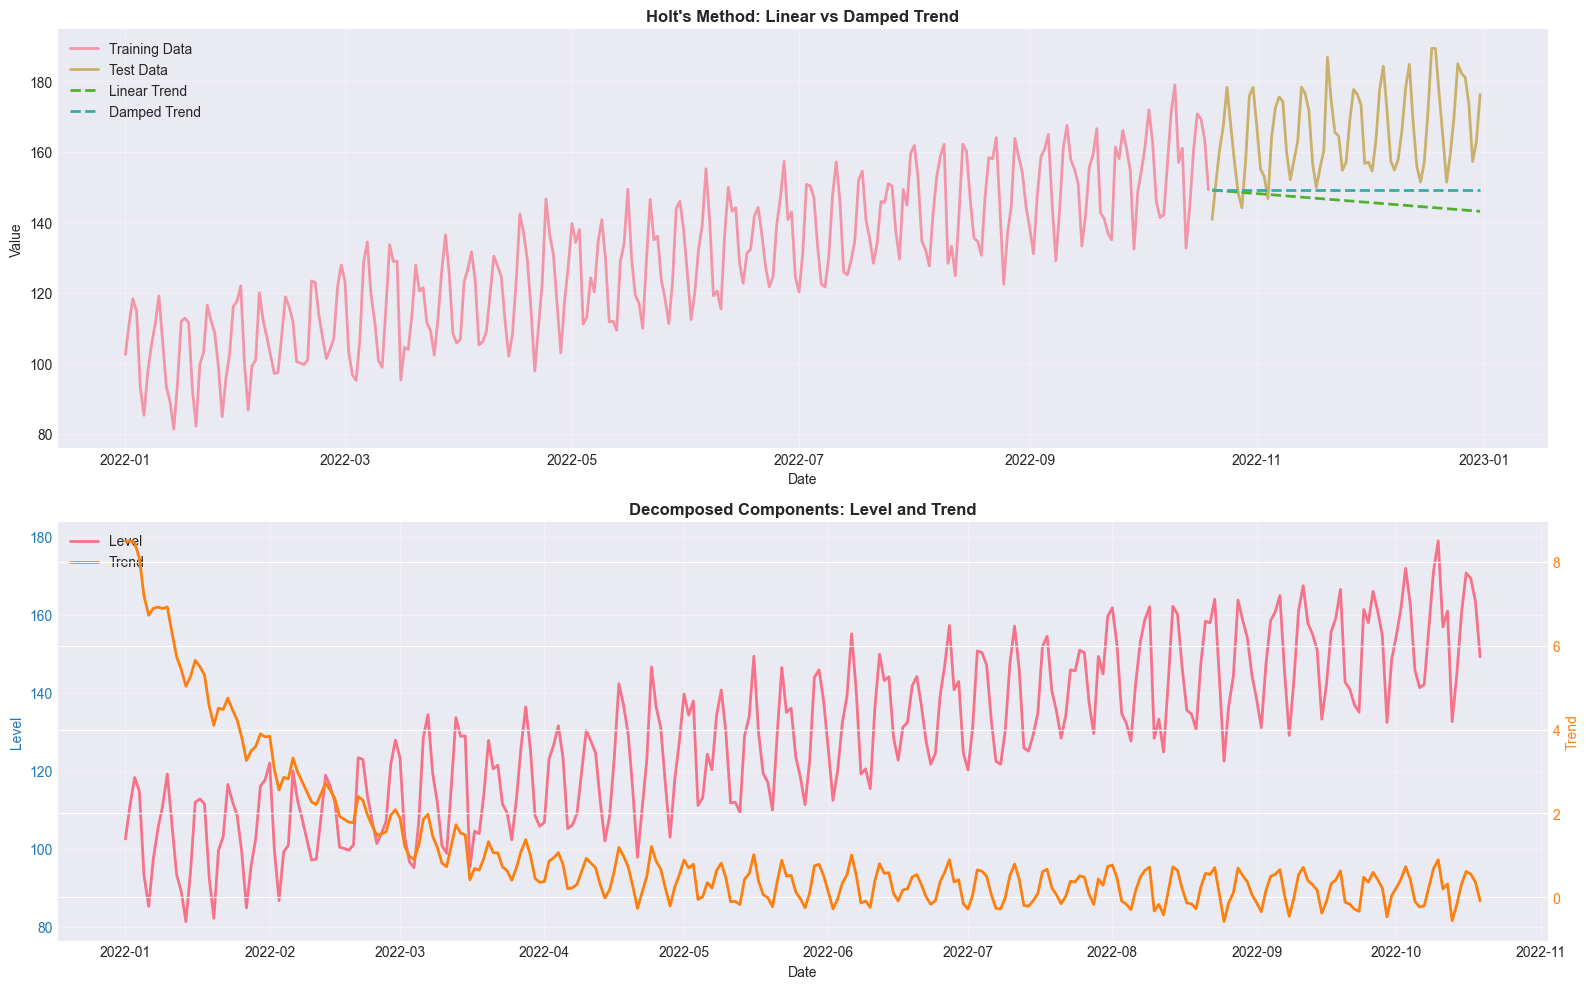

In [9]:
# Visualize Holt's method
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Forecasts comparison
axes[0].plot(train_weekly.index, train_weekly['value'], 
             label='Training Data', linewidth=2, alpha=0.7)
axes[0].plot(test_weekly.index, test_weekly['value'], 
             label='Test Data', linewidth=2, alpha=0.7)
axes[0].plot(test_weekly.index, forecast_linear, 
             label='Linear Trend', linewidth=2, linestyle='--')
axes[0].plot(test_weekly.index, forecast_damped, 
             label='Damped Trend', linewidth=2, linestyle='--')
axes[0].set_title('Holt\'s Method: Linear vs Damped Trend', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Components (level and trend)
level_linear = fitted_linear.level
trend_linear = fitted_linear.trend

ax1 = axes[1]
ax1.plot(train_weekly.index, level_linear, label='Level', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Level', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(train_weekly.index, trend_linear, label='Trend', 
         linewidth=2, color='tab:orange')
ax2.set_ylabel('Trend', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

axes[1].set_title('Decomposed Components: Level and Trend', 
                  fontsize=12, fontweight='bold')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

### 2.3 Holt-Winters Seasonal Method

**Models**: ETS(A,A,A) or ETS(A,A,M)

Extends Holt's method to capture seasonality.

**Additive Seasonality** (constant amplitude):
- Level: $l_t = \alpha(y_t - s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$
- Seasonal: $s_t = \gamma(y_t - l_t) + (1-\gamma)s_{t-m}$
- Forecast: $\hat{y}_{t+h} = l_t + h \cdot b_t + s_{t+h-m}$

**Multiplicative Seasonality** (changing amplitude):
- Level: $l_t = \alpha(y_t / s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$
- Seasonal: $s_t = \gamma(y_t / l_t) + (1-\gamma)s_{t-m}$
- Forecast: $\hat{y}_{t+h} = (l_t + h \cdot b_t) \times s_{t+h-m}$

Where $m$ is the seasonal period.

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters models

# Additive seasonality
hw_add = ExponentialSmoothing(
    train_weekly['value'],
    seasonal_periods=7,  # Weekly seasonality
    trend='add',
    seasonal='add'
)
fitted_hw_add = hw_add.fit()

# Multiplicative seasonality
hw_mul = ExponentialSmoothing(
    train_weekly['value'],
    seasonal_periods=7,
    trend='add',
    seasonal='mul'
)
fitted_hw_mul = hw_mul.fit()

# Damped trend with additive seasonality
hw_damped = ExponentialSmoothing(
    train_weekly['value'],
    seasonal_periods=7,
    trend='add',
    seasonal='add',
    damped_trend=True
)
fitted_hw_damped = hw_damped.fit()

# Generate forecasts
forecast_hw_add = fitted_hw_add.forecast(steps=len(test_weekly))
forecast_hw_mul = fitted_hw_mul.forecast(steps=len(test_weekly))
forecast_hw_damped = fitted_hw_damped.forecast(steps=len(test_weekly))

print("Holt-Winters Additive Seasonality:")
print(f"  α (level): {fitted_hw_add.params['smoothing_level']:.4f}")
print(f"  β (trend): {fitted_hw_add.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal): {fitted_hw_add.params['smoothing_seasonal']:.4f}")
print(f"  AIC: {fitted_hw_add.aic:.2f}")
print(f"  BIC: {fitted_hw_add.bic:.2f}")

print("\nHolt-Winters Multiplicative Seasonality:")
print(f"  α (level): {fitted_hw_mul.params['smoothing_level']:.4f}")
print(f"  β (trend): {fitted_hw_mul.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal): {fitted_hw_mul.params['smoothing_seasonal']:.4f}")
print(f"  AIC: {fitted_hw_mul.aic:.2f}")
print(f"  BIC: {fitted_hw_mul.bic:.2f}")

print("\nHolt-Winters Damped Trend + Additive Seasonality:")
print(f"  α (level): {fitted_hw_damped.params['smoothing_level']:.4f}")
print(f"  β (trend): {fitted_hw_damped.params['smoothing_trend']:.4f}")
print(f"  γ (seasonal): {fitted_hw_damped.params['smoothing_seasonal']:.4f}")
print(f"  φ (damping): {fitted_hw_damped.params['damping_trend']:.4f}")
print(f"  AIC: {fitted_hw_damped.aic:.2f}")
print(f"  BIC: {fitted_hw_damped.bic:.2f}")

Holt-Winters Additive Seasonality:
  α (level): 0.0000
  β (trend): 0.0000
  γ (seasonal): 0.0000
  AIC: 951.81
  BIC: 992.25

Holt-Winters Multiplicative Seasonality:
  α (level): 0.0000
  β (trend): 0.0000
  γ (seasonal): 0.0732
  AIC: 978.83
  BIC: 1019.27

Holt-Winters Damped Trend + Additive Seasonality:
  α (level): 0.0363
  β (trend): 0.0363
  γ (seasonal): 0.0000
  φ (damping): 0.9950
  AIC: 968.46
  BIC: 1012.59


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


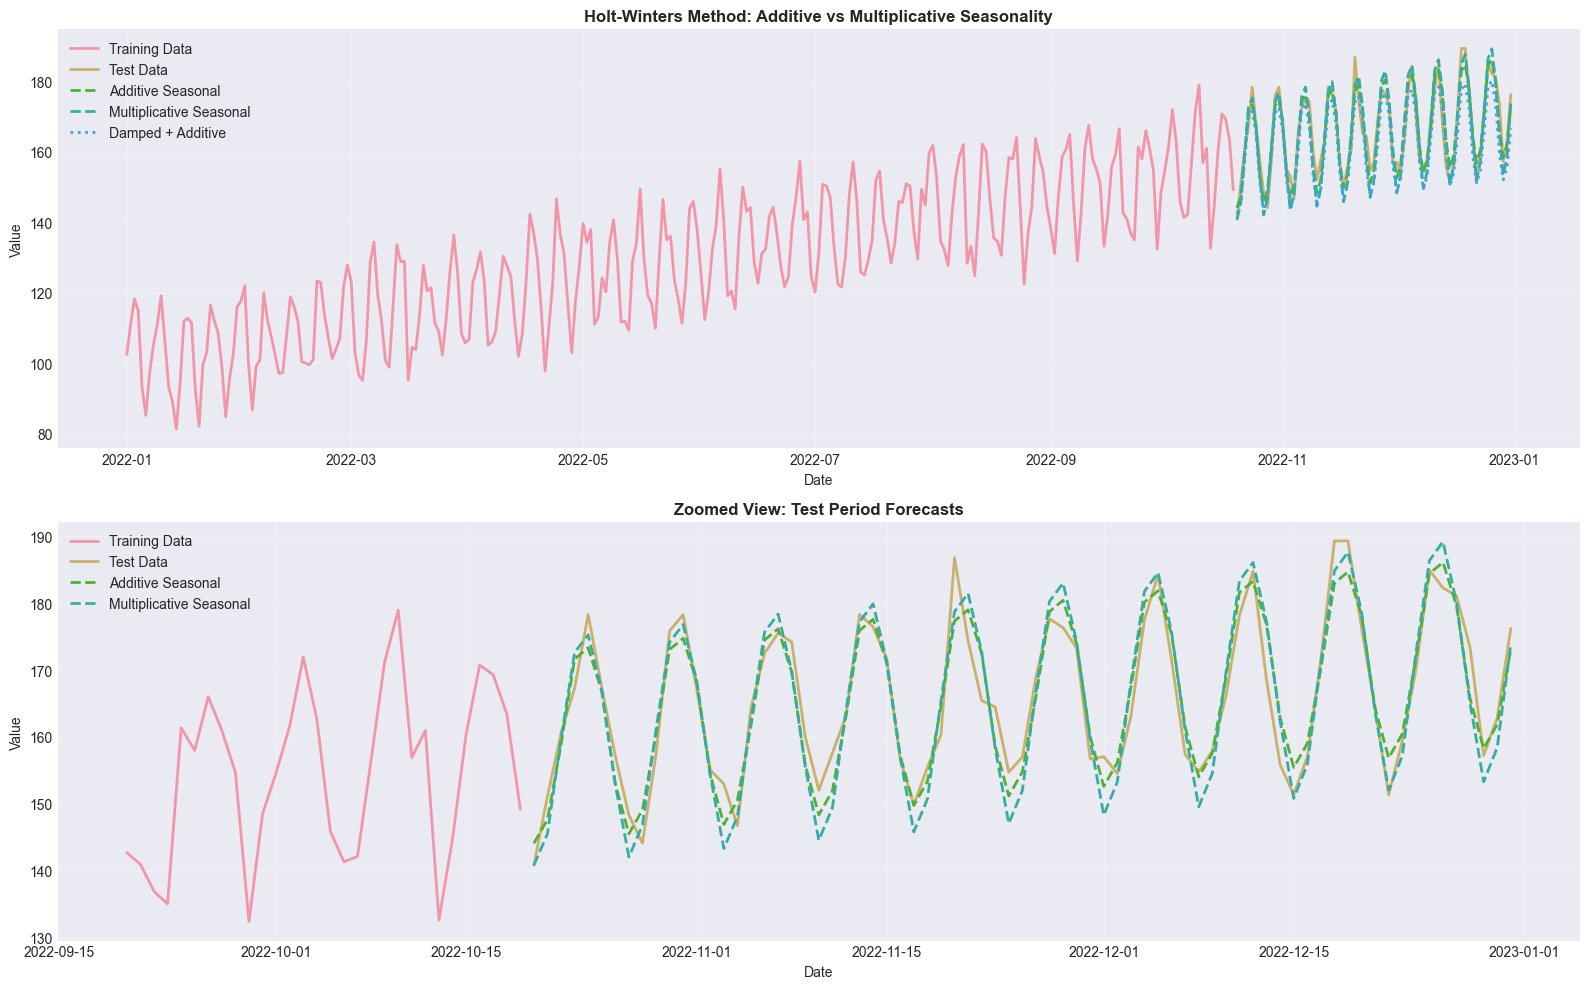

In [11]:
# Visualize Holt-Winters forecasts
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Top: Forecast comparison
axes[0].plot(train_weekly.index, train_weekly['value'], 
             label='Training Data', linewidth=2, alpha=0.7)
axes[0].plot(test_weekly.index, test_weekly['value'], 
             label='Test Data', linewidth=2, alpha=0.7)
axes[0].plot(test_weekly.index, forecast_hw_add, 
             label='Additive Seasonal', linewidth=2, linestyle='--')
axes[0].plot(test_weekly.index, forecast_hw_mul, 
             label='Multiplicative Seasonal', linewidth=2, linestyle='--')
axes[0].plot(test_weekly.index, forecast_hw_damped, 
             label='Damped + Additive', linewidth=2, linestyle=':')
axes[0].set_title('Holt-Winters Method: Additive vs Multiplicative Seasonality', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Zoom on test period
last_30_train = train_weekly.iloc[-30:]
axes[1].plot(last_30_train.index, last_30_train['value'], 
             label='Training Data', linewidth=2, alpha=0.7)
axes[1].plot(test_weekly.index, test_weekly['value'], 
             label='Test Data', linewidth=2, alpha=0.7)
axes[1].plot(test_weekly.index, forecast_hw_add, 
             label='Additive Seasonal', linewidth=2, linestyle='--')
axes[1].plot(test_weekly.index, forecast_hw_mul, 
             label='Multiplicative Seasonal', linewidth=2, linestyle='--')
axes[1].set_title('Zoomed View: Test Period Forecasts', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

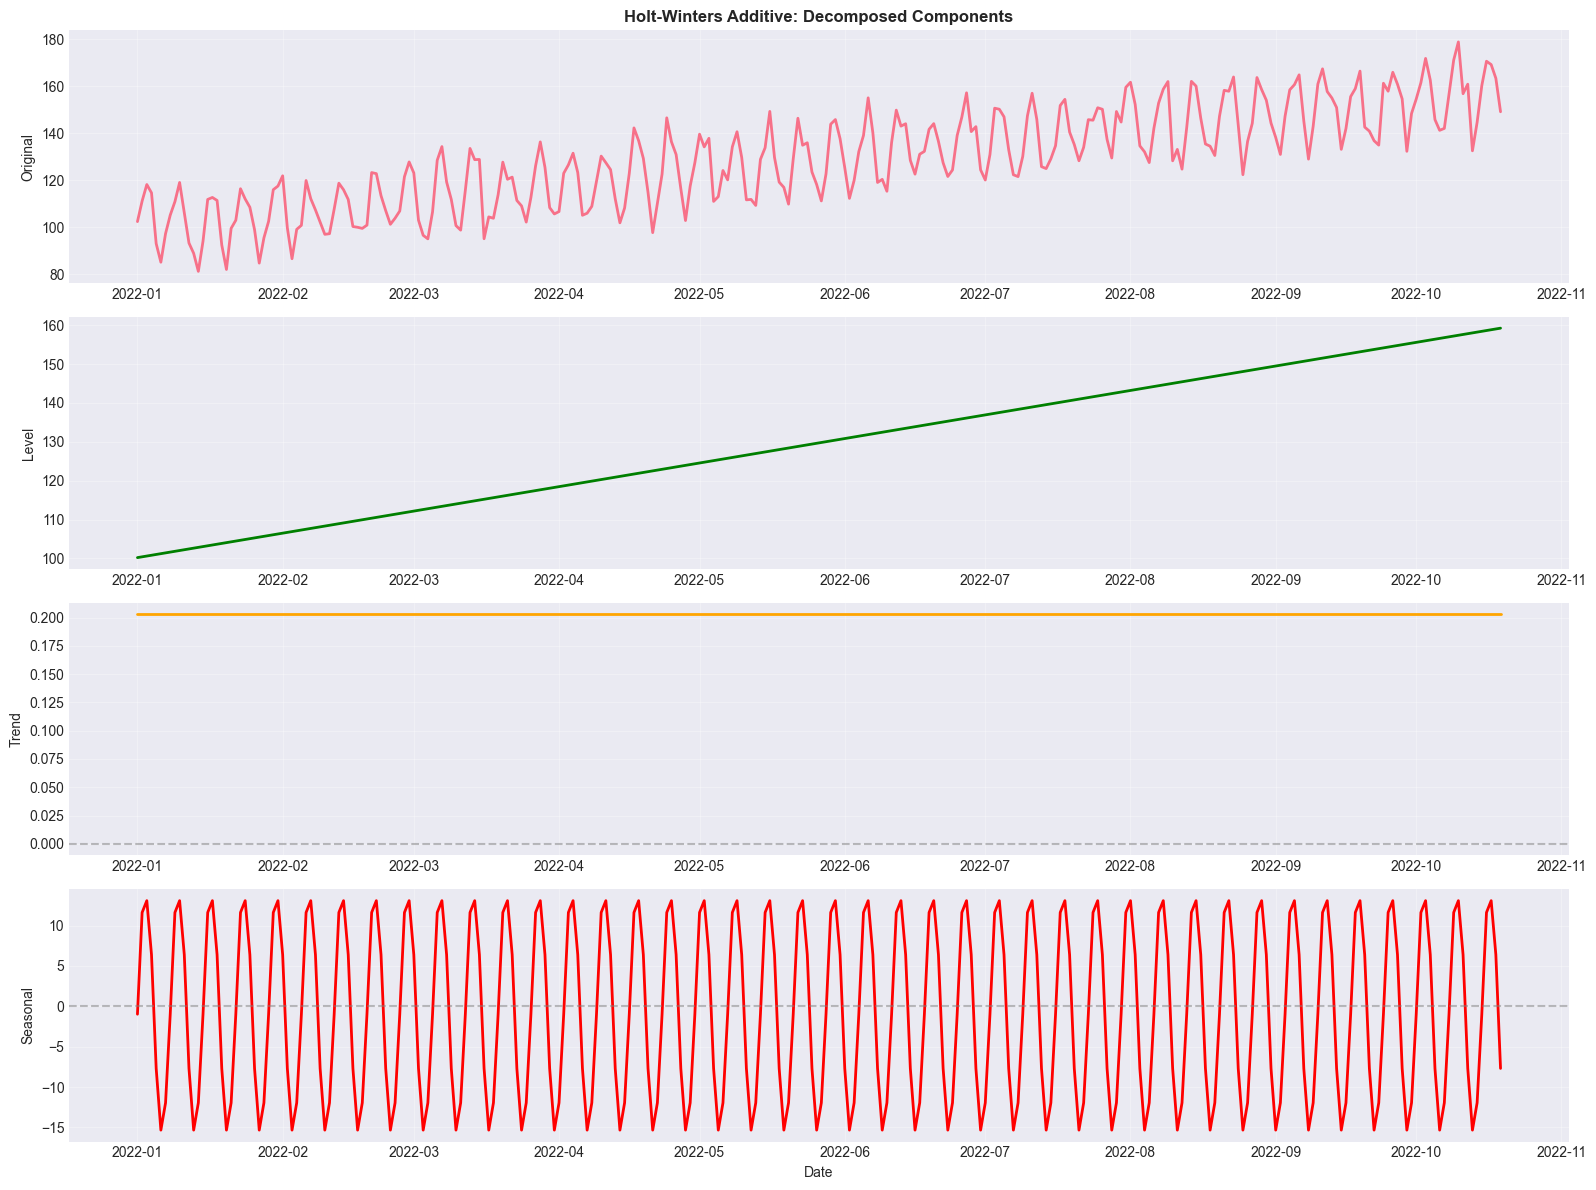

In [12]:
# Extract and visualize Holt-Winters components
def plot_hw_components(fitted_model, data, title):
    """
    Plot decomposed components from Holt-Winters model.
    """
    fig, axes = plt.subplots(4, 1, figsize=(16, 12))
    
    # Original series
    axes[0].plot(data.index, data['value'], linewidth=2)
    axes[0].set_ylabel('Original', fontsize=10)
    axes[0].set_title(title, fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Level
    axes[1].plot(data.index, fitted_model.level, linewidth=2, color='green')
    axes[1].set_ylabel('Level', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Trend
    axes[2].plot(data.index, fitted_model.trend, linewidth=2, color='orange')
    axes[2].set_ylabel('Trend', fontsize=10)
    axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[2].grid(True, alpha=0.3)
    
    # Seasonal
    axes[3].plot(data.index, fitted_model.season, linewidth=2, color='red')
    axes[3].set_ylabel('Seasonal', fontsize=10)
    axes[3].set_xlabel('Date', fontsize=10)
    axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot components
plot_hw_components(
    fitted_hw_add, 
    train_weekly, 
    'Holt-Winters Additive: Decomposed Components'
)

### 2.4 Model Selection with AIC/BIC

**Akaike Information Criterion (AIC)**:
$$AIC = -2 \log(L) + 2k$$

**Bayesian Information Criterion (BIC)**:
$$BIC = -2 \log(L) + k \log(n)$$

Where:
- $L$ is the likelihood
- $k$ is the number of parameters
- $n$ is the number of observations

**Lower values indicate better models**. BIC penalizes complexity more heavily than AIC.


Model Comparison (sorted by AIC):
            Model         AIC         BIC  Parameters
        Simple ES  758.676467  764.826814          10
      HW Additive  951.806382  992.250674          10
        HW Damped  968.464594 1012.585640          10
HW Multiplicative  978.830474 1019.274766          10
      Holt Damped 1446.529735 1464.913504          10
      Holt Linear 1461.212613 1475.919628          10


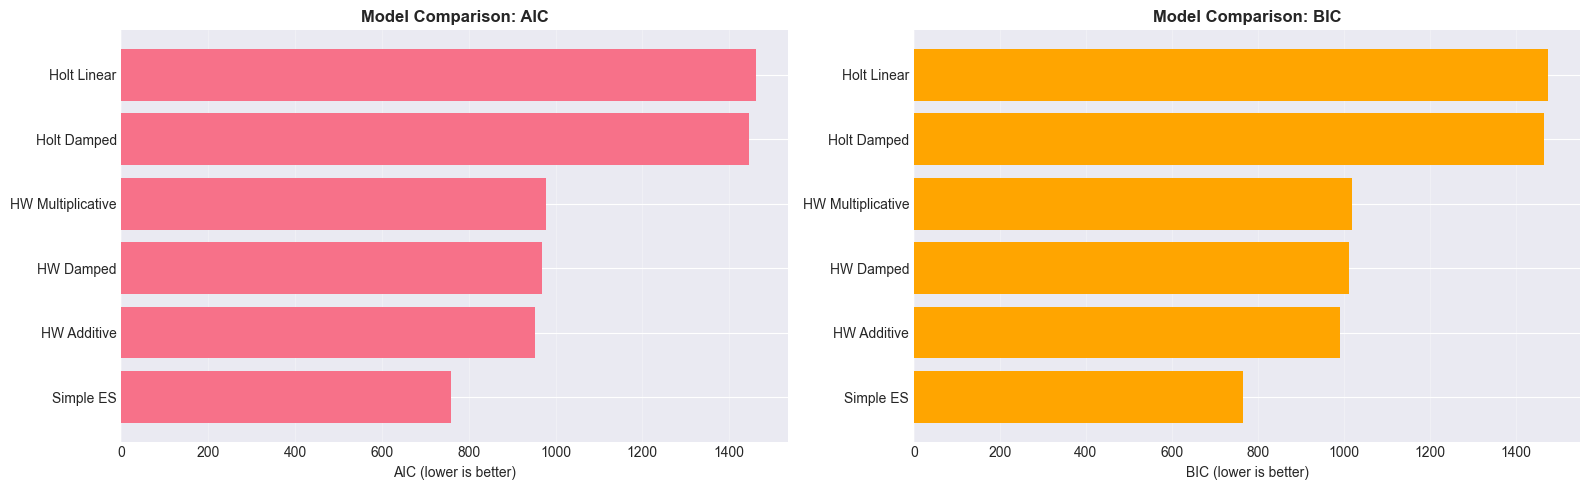

In [13]:
# Compare different ETS models
models_comparison = [
    ('Simple ES', fitted_auto),
    ('Holt Linear', fitted_linear),
    ('Holt Damped', fitted_damped),
    ('HW Additive', fitted_hw_add),
    ('HW Multiplicative', fitted_hw_mul),
    ('HW Damped', fitted_hw_damped)
]

# Create comparison DataFrame
comparison_data = []
for name, model in models_comparison:
    comparison_data.append({
        'Model': name,
        'AIC': model.aic,
        'BIC': model.bic,
        'Parameters': len(model.params)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('AIC')

print("\nModel Comparison (sorted by AIC):")
print(comparison_df.to_string(index=False))

# Visualize model selection criteria
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# AIC comparison
axes[0].barh(comparison_df['Model'], comparison_df['AIC'])
axes[0].set_xlabel('AIC (lower is better)')
axes[0].set_title('Model Comparison: AIC', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# BIC comparison
axes[1].barh(comparison_df['Model'], comparison_df['BIC'], color='orange')
axes[1].set_xlabel('BIC (lower is better)')
axes[1].set_title('Model Comparison: BIC', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 3. STL Decomposition (Seasonal and Trend using Loess)

**STL** is a versatile and robust method for decomposing time series.

### Advantages of STL

1. **Handles any type of seasonality**: Not limited to additive/multiplicative
2. **Robust to outliers**: Uses LOESS smoothing which is resistant to anomalies
3. **Seasonal component can change over time**: More flexible than classical methods
4. **Multiple seasonal periods**: Can model daily, weekly, yearly patterns simultaneously

### Key Parameters

- **seasonal**: Length of seasonal smoother (must be odd)
  - Larger values: smoother seasonal component
  - Smaller values: more variable seasonal pattern

- **trend**: Length of trend smoother
  - Larger values: smoother trend
  - Recommendation: trend ≥ (1.5 × seasonal_period) / (1 - 1.5/seasonal)

- **seasonal_deg**: Degree of seasonal LOESS (0 or 1)
- **trend_deg**: Degree of trend LOESS (0 or 1)
- **robust**: If True, uses robust weights to handle outliers

### 3.1 Single Seasonal Period STL

In [14]:
from statsmodels.tsa.seasonal import STL

# Apply STL to weekly data
stl_weekly = STL(
    ts_weekly_additive['value'],
    seasonal=7,  # Weekly seasonality
    trend=None,  # Auto-calculate
    robust=True  # Robust to outliers
)

result_stl_weekly = stl_weekly.fit()

print("STL Decomposition Results:")
print(f"Seasonal period: 7 days")
print(f"Trend window: Auto")
print(f"\nComponent statistics:")
print(f"  Trend range: [{result_stl_weekly.trend.min():.2f}, {result_stl_weekly.trend.max():.2f}]")
print(f"  Seasonal range: [{result_stl_weekly.seasonal.min():.2f}, {result_stl_weekly.seasonal.max():.2f}]")
print(f"  Residual std: {result_stl_weekly.resid.std():.2f}")

STL Decomposition Results:
Seasonal period: 7 days
Trend window: Auto

Component statistics:
  Trend range: [101.25, 177.38]
  Seasonal range: [-19.96, 18.71]
  Residual std: 4.01


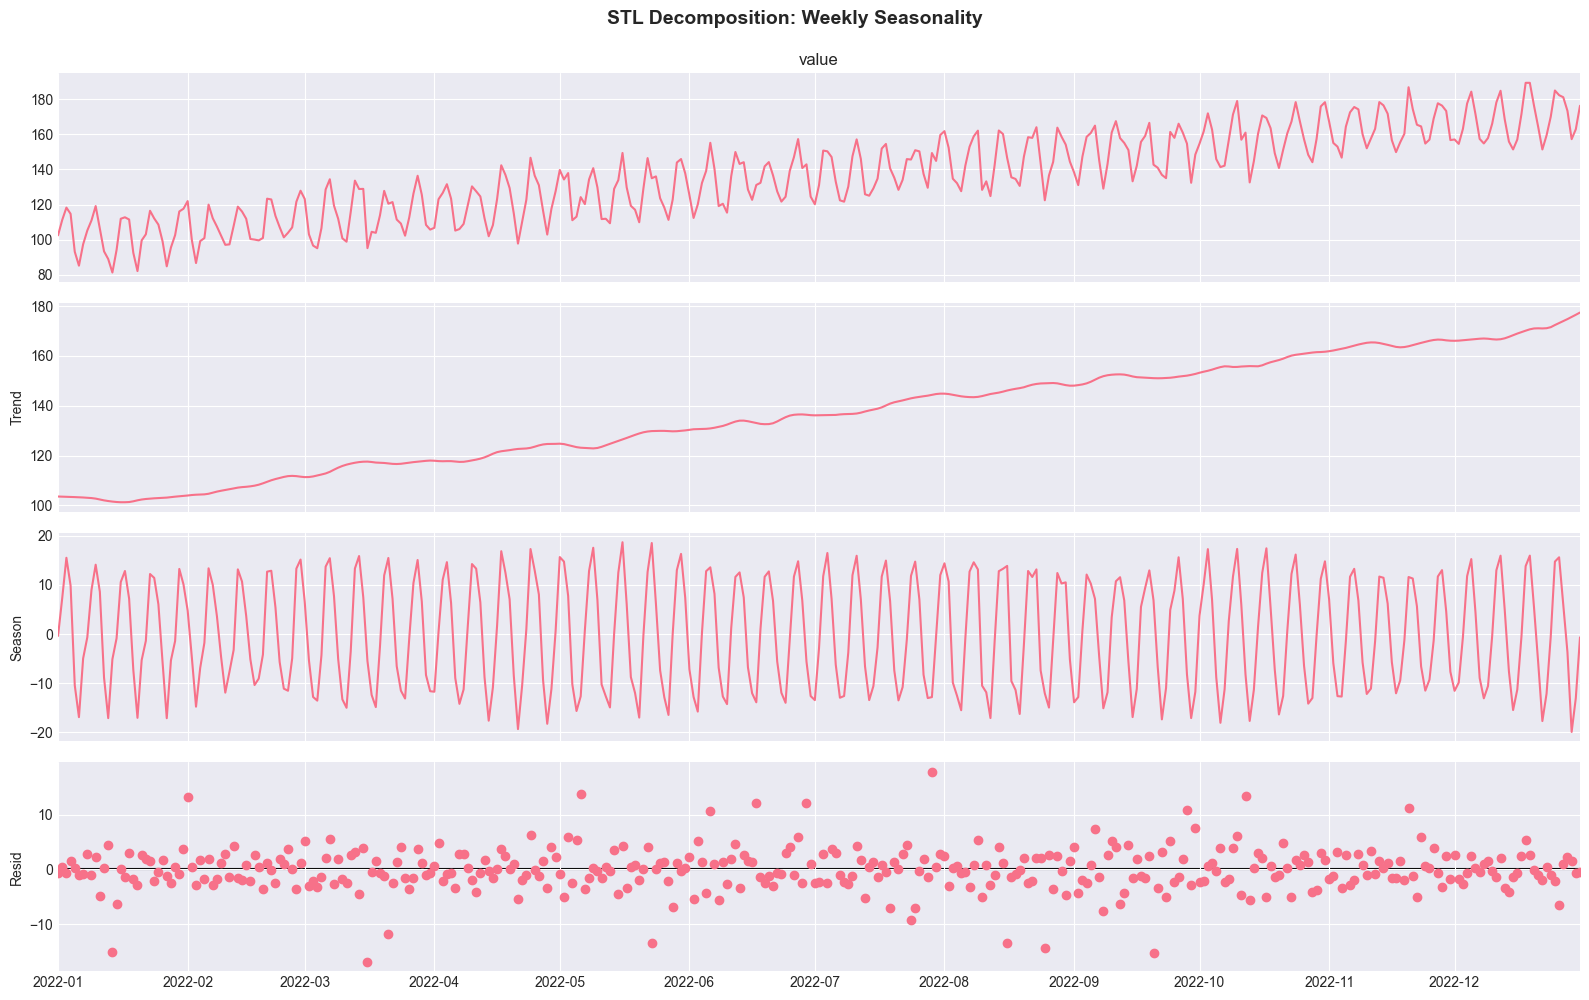

In [15]:
# Visualize STL decomposition
fig = result_stl_weekly.plot()
fig.set_size_inches(16, 10)
fig.suptitle('STL Decomposition: Weekly Seasonality', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 3.2 Strength of Seasonality and Trend

**Strength of Seasonality**:
$$F_S = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_t + R_t)}\right)$$

**Strength of Trend**:
$$F_T = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t + R_t)}\right)$$

Where:
- $S_t$ is the seasonal component
- $T_t$ is the trend component
- $R_t$ is the remainder

**Interpretation**:
- Values close to 0: weak component
- Values close to 1: strong component

Component Strength Metrics:
  Strength of Trend: 0.9663
  Strength of Seasonality: 0.8781


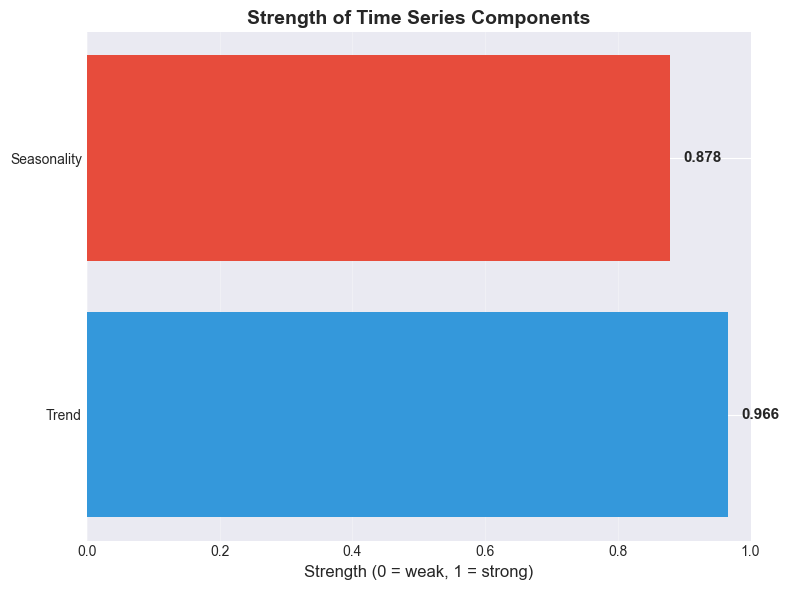

In [16]:
def calculate_strength(decomposition) -> Tuple[float, float]:
    """
    Calculate strength of trend and seasonality from STL decomposition.
    
    Returns
    -------
    Tuple[float, float]
        (strength_of_trend, strength_of_seasonality)
    """
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid
    
    # Remove NaN values
    valid_idx = ~(np.isnan(trend) | np.isnan(seasonal) | np.isnan(resid))
    trend = trend[valid_idx]
    seasonal = seasonal[valid_idx]
    resid = resid[valid_idx]
    
    # Calculate variances
    var_resid = np.var(resid)
    var_trend_resid = np.var(trend + resid)
    var_seasonal_resid = np.var(seasonal + resid)
    
    # Calculate strengths
    strength_trend = max(0, 1 - var_resid / var_trend_resid) if var_trend_resid > 0 else 0
    strength_seasonal = max(0, 1 - var_resid / var_seasonal_resid) if var_seasonal_resid > 0 else 0
    
    return strength_trend, strength_seasonal

# Calculate strengths
strength_t, strength_s = calculate_strength(result_stl_weekly)

print("Component Strength Metrics:")
print(f"  Strength of Trend: {strength_t:.4f}")
print(f"  Strength of Seasonality: {strength_s:.4f}")

# Visualize strengths
fig, ax = plt.subplots(figsize=(8, 6))
strengths = [strength_t, strength_s]
labels = ['Trend', 'Seasonality']
colors = ['#3498db', '#e74c3c']

bars = ax.barh(labels, strengths, color=colors)
ax.set_xlabel('Strength (0 = weak, 1 = strong)', fontsize=12)
ax.set_title('Strength of Time Series Components', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, strength in zip(bars, strengths):
    ax.text(strength + 0.02, bar.get_y() + bar.get_height()/2, 
            f'{strength:.3f}', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.3 Multiple Seasonal Periods with MSTL

**MSTL** (Multiple Seasonal-Trend decomposition using LOESS) extends STL to handle multiple seasonal periods.

**Use cases**:
- Hourly data with daily (24) and weekly (168) seasonality
- Daily data with weekly (7) and yearly (365) seasonality
- Transaction data with intraday, weekly, and monthly patterns

In [17]:
from statsmodels.tsa.seasonal import MSTL

# Apply MSTL to data with multiple seasonalities
mstl = MSTL(
    ts_multiple['value'],
    periods=[7, 365],  # Weekly and yearly seasonality
    windows=[7, 365],  # Seasonal smoothing windows
    iterate=2
)

result_mstl = mstl.fit()

print("MSTL Decomposition Results:")
print(f"Seasonal periods: {[7, 365]} (weekly, yearly)")
print(f"\nComponent statistics:")
print(f"  Trend range: [{result_mstl.trend.min():.2f}, {result_mstl.trend.max():.2f}]")

# Note: In statsmodels, result_mstl.seasonal is a pandas Series containing
# the SUM of all seasonal components (weekly + yearly), not individual components.
# This is the intended behavior of the MSTL implementation.
combined_seasonal = result_mstl.seasonal

print(f"  Combined seasonal range: [{combined_seasonal.min():.2f}, {combined_seasonal.max():.2f}]")
print(f"  Residual std: {result_mstl.resid.std():.2f}")
print(f"\nNote: The seasonal component contains the combined effect of both weekly (7-day) and yearly (365-day) seasonality.")

MSTL Decomposition Results:
Seasonal periods: [7, 365] (weekly, yearly)

Component statistics:
  Trend range: [146.63, 371.93]
  Combined seasonal range: [-14.84, 16.18]
  Residual std: 4.36

Note: The seasonal component contains the combined effect of both weekly (7-day) and yearly (365-day) seasonality.


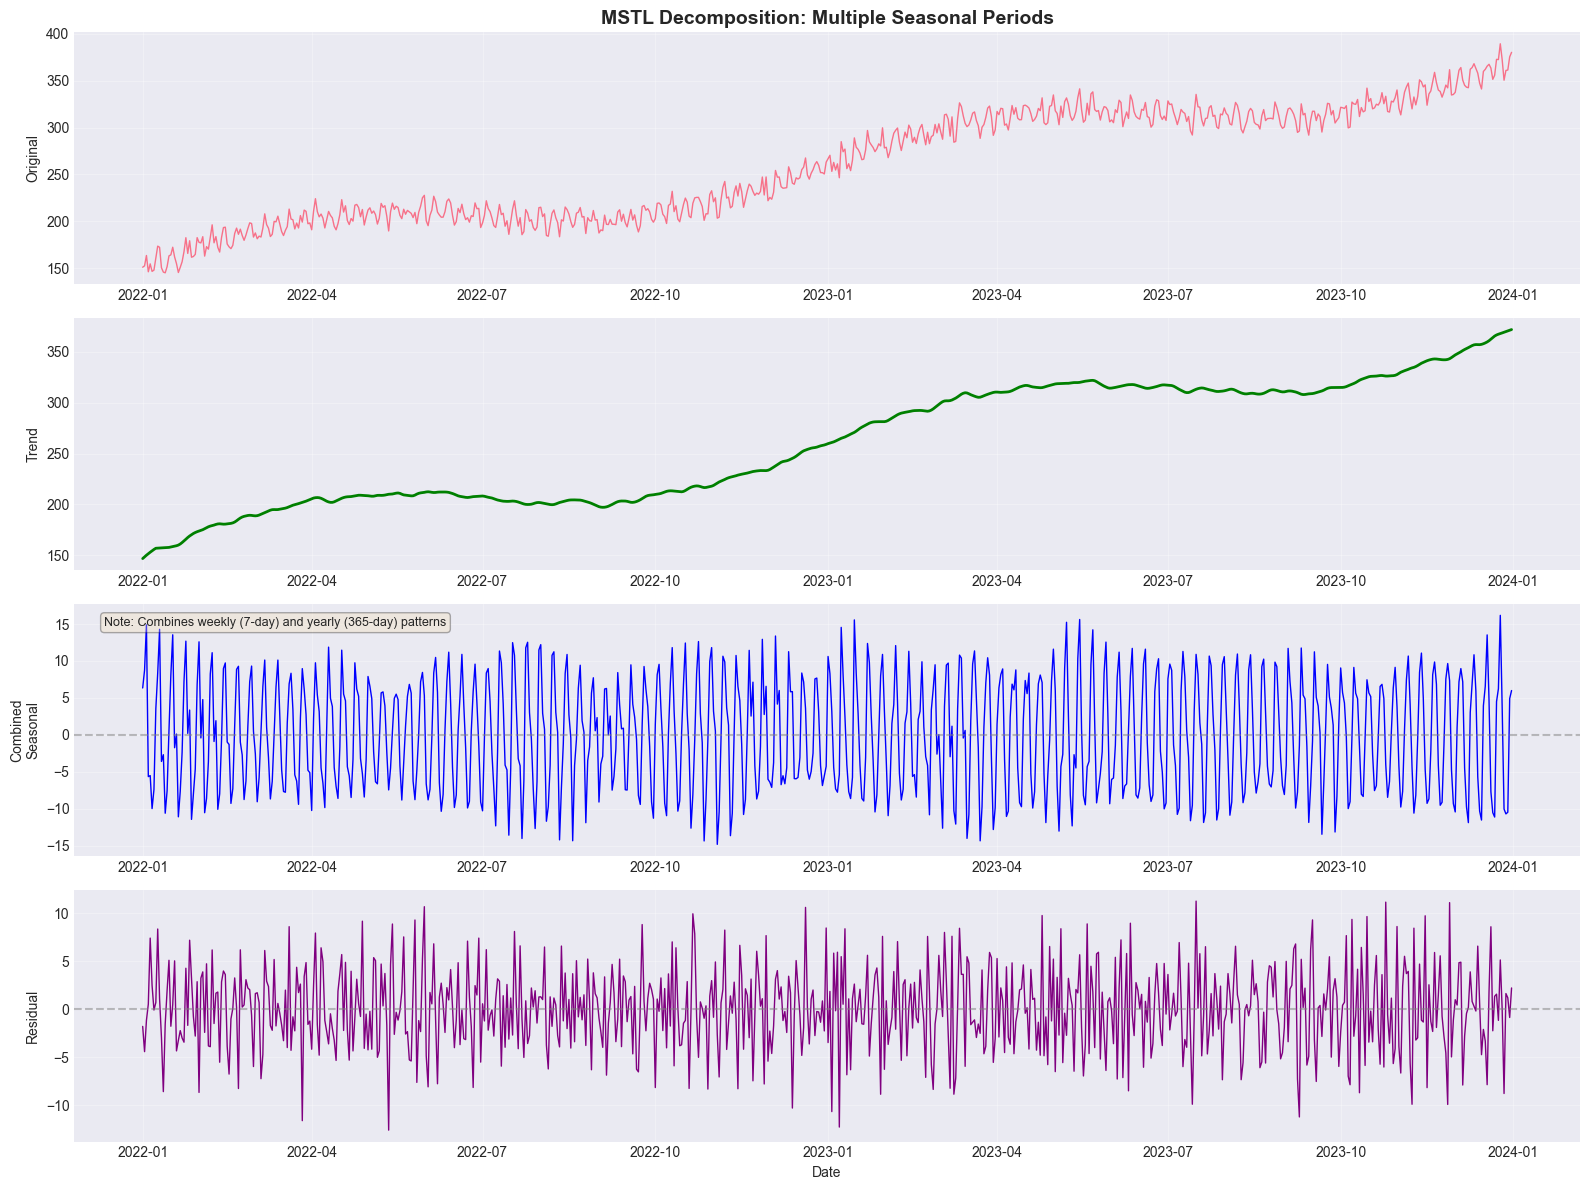

In [18]:
# Visualize MSTL decomposition
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
axes[0].plot(ts_multiple.index, ts_multiple['value'], linewidth=1)
axes[0].set_ylabel('Original', fontsize=10)
axes[0].set_title('MSTL Decomposition: Multiple Seasonal Periods', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Trend
axes[1].plot(ts_multiple.index, result_mstl.trend, linewidth=2, color='green')
axes[1].set_ylabel('Trend', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Combined Seasonal (weekly + yearly)
axes[2].plot(ts_multiple.index, combined_seasonal, linewidth=1, color='blue')
axes[2].set_ylabel('Combined\nSeasonal', fontsize=10)
axes[2].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, 'Note: Combines weekly (7-day) and yearly (365-day) patterns', 
             transform=axes[2].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Residual
axes[3].plot(ts_multiple.index, result_mstl.resid, linewidth=1, color='purple')
axes[3].set_ylabel('Residual', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

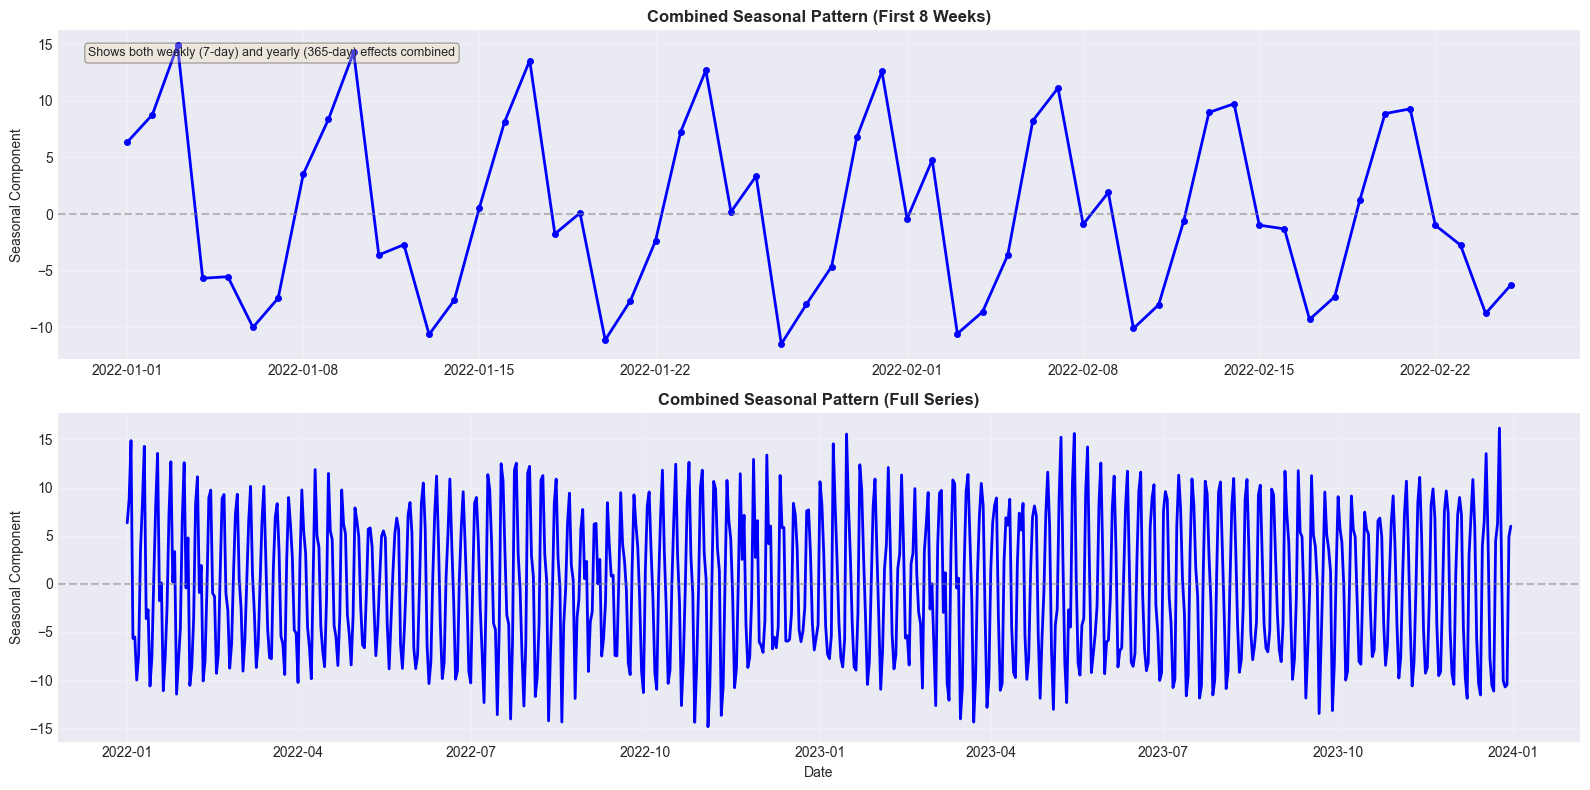

In [19]:
# Zoom in on combined seasonal pattern
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Combined seasonal pattern - first 8 weeks
n_days = 56
axes[0].plot(ts_multiple.index[:n_days], combined_seasonal[:n_days], 
             marker='o', linewidth=2, markersize=4, color='blue')
axes[0].set_title('Combined Seasonal Pattern (First 8 Weeks)', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Seasonal Component')
axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, 'Shows both weekly (7-day) and yearly (365-day) effects combined', 
             transform=axes[0].transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Combined seasonal pattern - full series
axes[1].plot(ts_multiple.index, combined_seasonal, linewidth=2, color='blue')
axes[1].set_title('Combined Seasonal Pattern (Full Series)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Seasonal Component')
axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.4 STL for Forecasting

STL can be combined with forecasting methods:

1. Decompose the series using STL
2. Forecast each component separately:
   - Trend: Linear regression, ARIMA, etc.
   - Seasonal: Naive seasonal forecast (repeat last period)
3. Combine forecasts: $\hat{y}_t = \hat{T}_t + \hat{S}_t$

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


STL + ARIMA Forecast:
  MAE: 12.32
  RMSE: 13.80


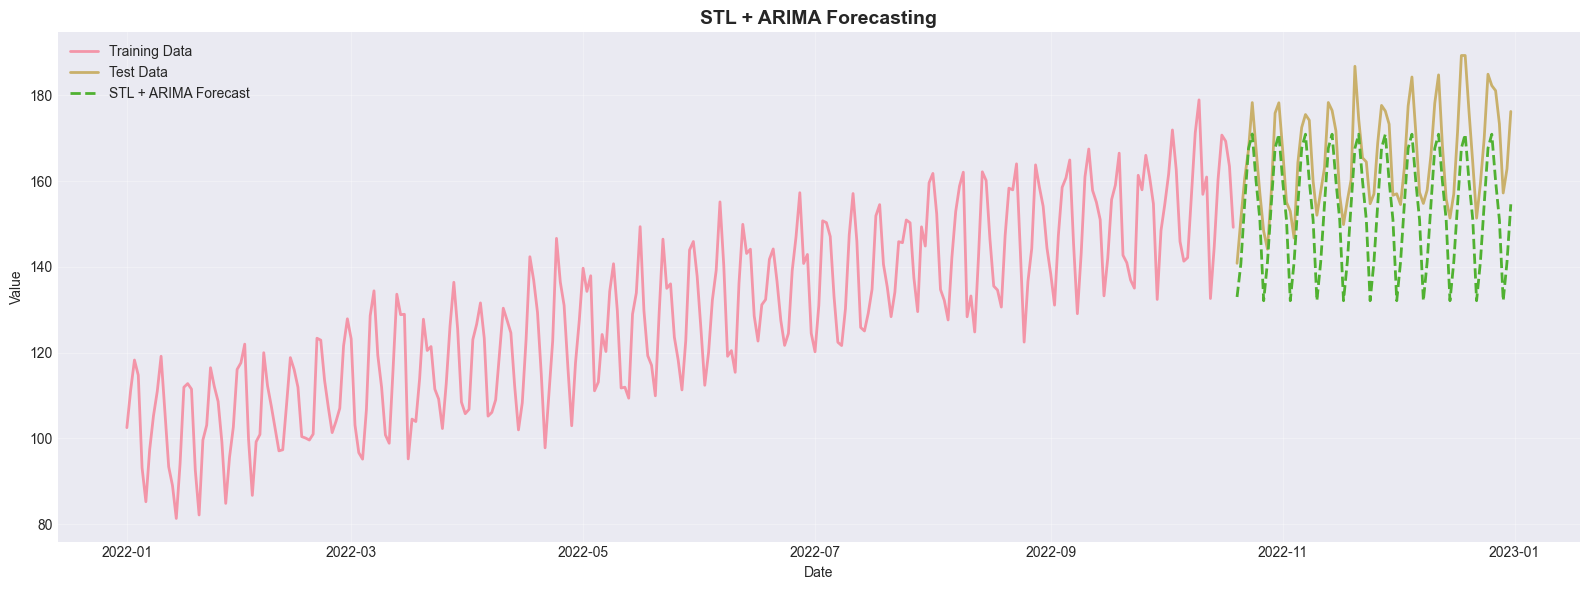

In [20]:
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# STL + ARIMA forecast
stlf = STLForecast(
    train_weekly['value'],
    ARIMA,
    model_kwargs=dict(order=(1, 1, 0)),
    period=7
)

stlf_result = stlf.fit()
stlf_forecast = stlf_result.forecast(steps=len(test_weekly))

# Calculate forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_stlf = mean_absolute_error(test_weekly['value'], stlf_forecast)
rmse_stlf = np.sqrt(mean_squared_error(test_weekly['value'], stlf_forecast))

print("STL + ARIMA Forecast:")
print(f"  MAE: {mae_stlf:.2f}")
print(f"  RMSE: {rmse_stlf:.2f}")

# Visualize forecast
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(train_weekly.index, train_weekly['value'], 
        label='Training Data', linewidth=2, alpha=0.7)
ax.plot(test_weekly.index, test_weekly['value'], 
        label='Test Data', linewidth=2, alpha=0.7)
ax.plot(test_weekly.index, stlf_forecast, 
        label='STL + ARIMA Forecast', linewidth=2, linestyle='--')

ax.set_title('STL + ARIMA Forecasting', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Comparison: ETS vs STL vs ARIMA

### When to Use Each Method

#### Exponential Smoothing (ETS)
**Best for:**
- Short to medium-term forecasts
- Data with clear trend and/or seasonality
- When interpretability is important
- Quick forecasts with minimal tuning

**Pros:**
- Simple and fast
- Interpretable smoothing parameters
- Good for stable patterns
- Automatic parameter optimization

**Cons:**
- Limited to specific trend/seasonal patterns
- Cannot capture complex dynamics
- Assumes constant smoothing parameters

#### STL Decomposition
**Best for:**
- Understanding time series structure
- Data with multiple seasonal periods
- Outlier detection and handling
- When seasonal pattern changes over time

**Pros:**
- Very flexible
- Robust to outliers
- Handles changing seasonality
- Multiple seasonal periods
- Great for exploratory analysis

**Cons:**
- Requires separate forecasting method
- More parameters to tune
- Can be computationally intensive

#### ARIMA
**Best for:**
- Data with autocorrelation structure
- Non-seasonal or simple seasonal patterns
- When you need statistical inference
- Medium to long-term forecasts

**Pros:**
- Flexible modeling of autocorrelation
- Statistical rigor (confidence intervals)
- Can handle non-stationary data
- Well-established theory

**Cons:**
- Requires stationarity
- Model selection can be complex
- Limited seasonality handling
- Less interpretable

### 4.1 Performance Benchmark

In [21]:
import time
from sklearn.metrics import mean_absolute_percentage_error

# Prepare data
train = train_weekly['value']
test = test_weekly['value']
n_forecast = len(test)

# Dictionary to store results
benchmark_results = []

# 1. Simple Exponential Smoothing
start_time = time.time()
model_ses = SimpleExpSmoothing(train)
fit_ses = model_ses.fit()
forecast_ses = fit_ses.forecast(steps=n_forecast)
time_ses = time.time() - start_time

benchmark_results.append({
    'Model': 'Simple ES',
    'MAE': mean_absolute_error(test, forecast_ses),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_ses)),
    'MAPE': mean_absolute_percentage_error(test, forecast_ses) * 100,
    'AIC': fit_ses.aic,
    'BIC': fit_ses.bic,
    'Time (s)': time_ses
})

# 2. Holt's Linear
start_time = time.time()
model_holt = Holt(train)
fit_holt = model_holt.fit()
forecast_holt = fit_holt.forecast(steps=n_forecast)
time_holt = time.time() - start_time

benchmark_results.append({
    'Model': 'Holt Linear',
    'MAE': mean_absolute_error(test, forecast_holt),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_holt)),
    'MAPE': mean_absolute_percentage_error(test, forecast_holt) * 100,
    'AIC': fit_holt.aic,
    'BIC': fit_holt.bic,
    'Time (s)': time_holt
})

# 3. Holt-Winters Additive
start_time = time.time()
model_hw = ExponentialSmoothing(train, seasonal_periods=7, trend='add', seasonal='add')
fit_hw = model_hw.fit()
forecast_hw = fit_hw.forecast(steps=n_forecast)
time_hw = time.time() - start_time

benchmark_results.append({
    'Model': 'Holt-Winters',
    'MAE': mean_absolute_error(test, forecast_hw),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_hw)),
    'MAPE': mean_absolute_percentage_error(test, forecast_hw) * 100,
    'AIC': fit_hw.aic,
    'BIC': fit_hw.bic,
    'Time (s)': time_hw
})

# 4. STL + ARIMA
start_time = time.time()
model_stlf = STLForecast(train, ARIMA, model_kwargs=dict(order=(1, 1, 0)), period=7)
fit_stlf = model_stlf.fit()
forecast_stlf = fit_stlf.forecast(steps=n_forecast)
time_stlf = time.time() - start_time

benchmark_results.append({
    'Model': 'STL + ARIMA',
    'MAE': mean_absolute_error(test, forecast_stlf),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_stlf)),
    'MAPE': mean_absolute_percentage_error(test, forecast_stlf) * 100,
    'AIC': np.nan,  # Not directly available
    'BIC': np.nan,
    'Time (s)': time_stlf
})

# 5. Auto ARIMA
start_time = time.time()
model_arima = ARIMA(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 7))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=n_forecast)
time_arima = time.time() - start_time

benchmark_results.append({
    'Model': 'SARIMA',
    'MAE': mean_absolute_error(test, forecast_arima),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_arima)),
    'MAPE': mean_absolute_percentage_error(test, forecast_arima) * 100,
    'AIC': fit_arima.aic,
    'BIC': fit_arima.bic,
    'Time (s)': time_arima
})

# Create DataFrame
benchmark_df = pd.DataFrame(benchmark_results)
benchmark_df = benchmark_df.sort_values('RMSE')

print("\nModel Performance Benchmark:")
print("=" * 100)
print(benchmark_df.to_string(index=False, float_format='%.3f'))
print("=" * 100)

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py-tidymodels2/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: Val


Model Performance Benchmark:
       Model    MAE   RMSE   MAPE      AIC      BIC  Time (s)
Holt-Winters  3.089  3.725  1.870  951.806  992.251     0.054
      SARIMA  3.118  3.783  1.884 1817.297 1835.663     0.218
 STL + ARIMA 12.323 13.800  7.464      NaN      NaN     0.011
   Simple ES 17.015 20.197  9.868 1439.829 1447.183     0.003
 Holt Linear 20.042 23.155 11.674 1461.213 1475.920     0.008


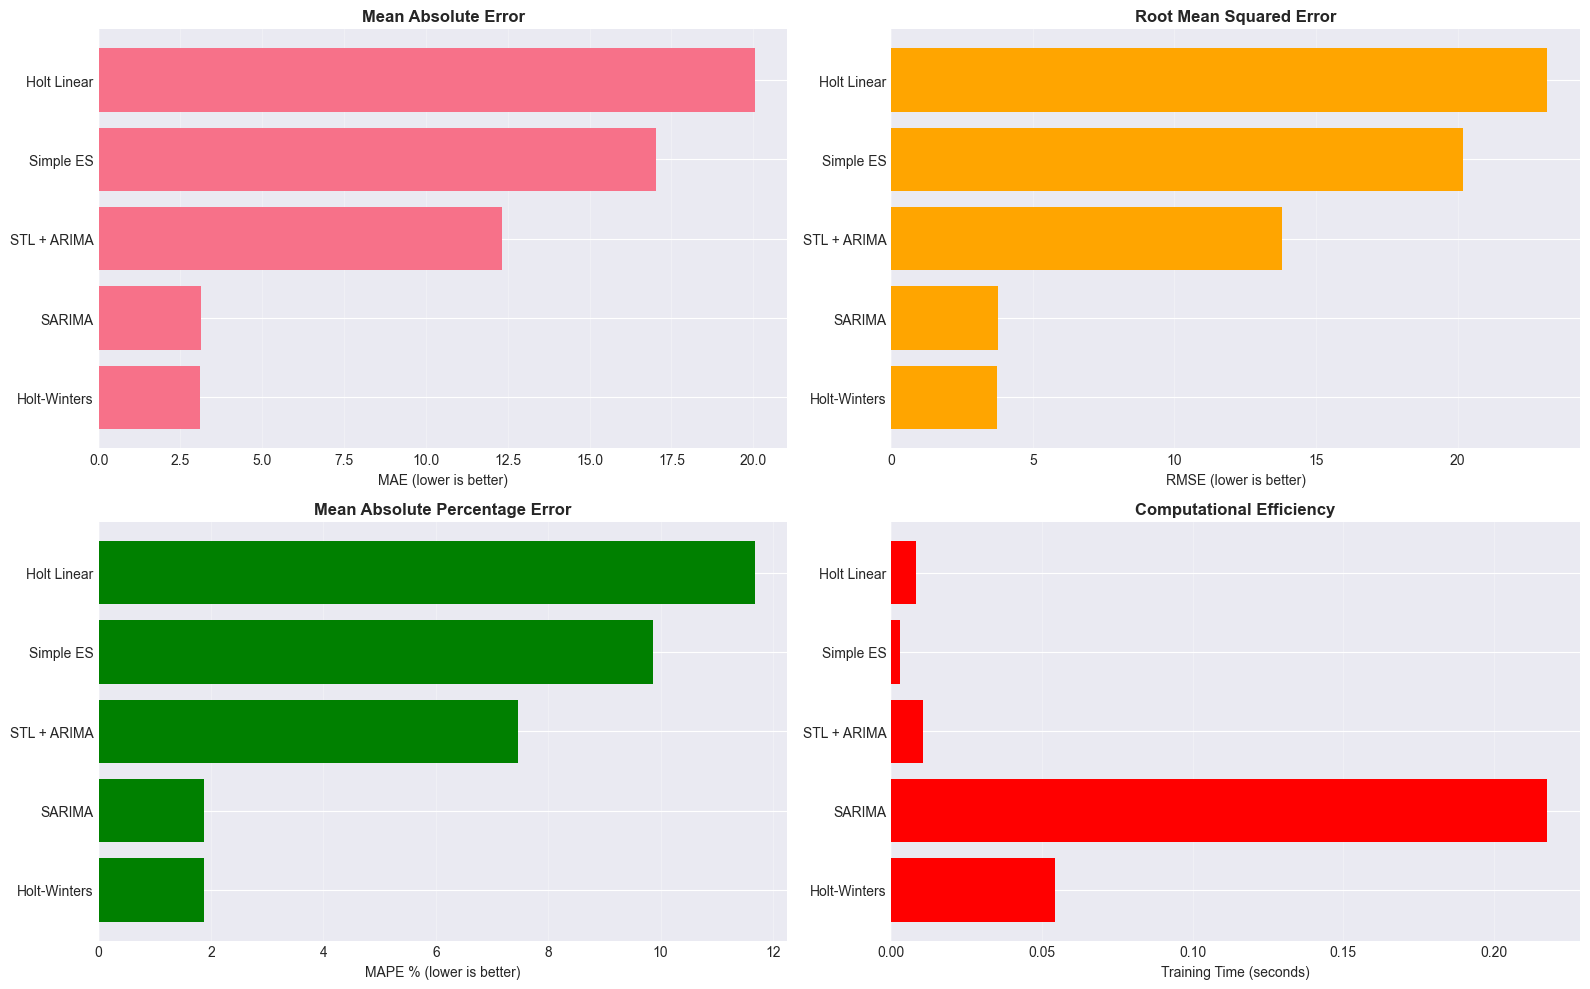

In [22]:
# Visualize benchmark results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# MAE
axes[0, 0].barh(benchmark_df['Model'], benchmark_df['MAE'])
axes[0, 0].set_xlabel('MAE (lower is better)')
axes[0, 0].set_title('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# RMSE
axes[0, 1].barh(benchmark_df['Model'], benchmark_df['RMSE'], color='orange')
axes[0, 1].set_xlabel('RMSE (lower is better)')
axes[0, 1].set_title('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# MAPE
axes[1, 0].barh(benchmark_df['Model'], benchmark_df['MAPE'], color='green')
axes[1, 0].set_xlabel('MAPE % (lower is better)')
axes[1, 0].set_title('Mean Absolute Percentage Error', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Training Time
axes[1, 1].barh(benchmark_df['Model'], benchmark_df['Time (s)'], color='red')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Computational Efficiency', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

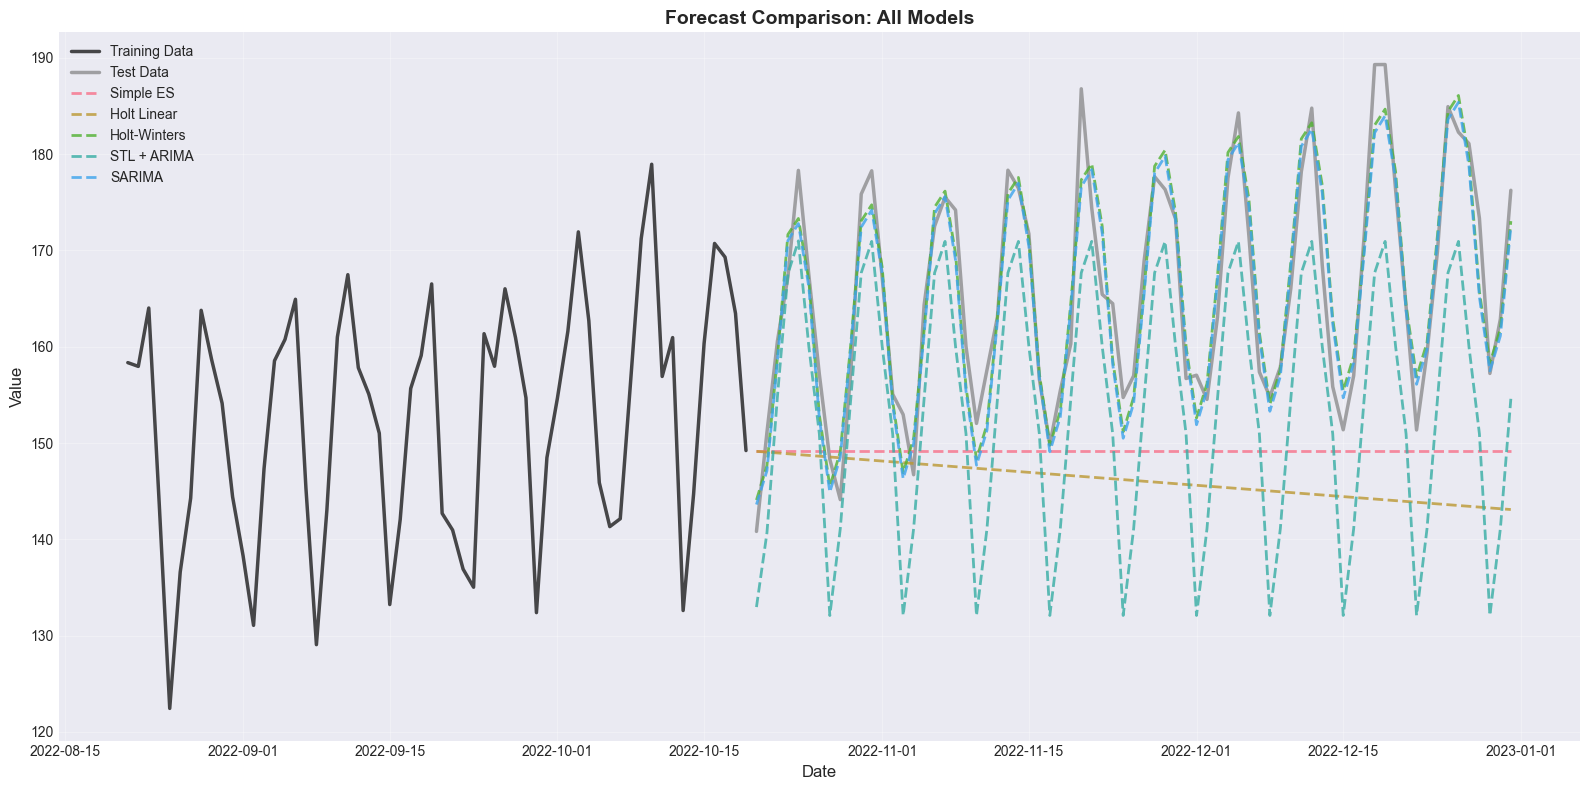

In [23]:
# Visual comparison of forecasts
fig, ax = plt.subplots(figsize=(16, 8))

# Plot last 60 days of training data
last_n = 60
ax.plot(train_weekly.index[-last_n:], train_weekly['value'][-last_n:], 
        label='Training Data', linewidth=2.5, alpha=0.7, color='black')

# Plot test data
ax.plot(test_weekly.index, test_weekly['value'], 
        label='Test Data', linewidth=2.5, alpha=0.7, color='gray')

# Plot forecasts
ax.plot(test_weekly.index, forecast_ses, label='Simple ES', 
        linewidth=2, linestyle='--', alpha=0.8)
ax.plot(test_weekly.index, forecast_holt, label='Holt Linear', 
        linewidth=2, linestyle='--', alpha=0.8)
ax.plot(test_weekly.index, forecast_hw, label='Holt-Winters', 
        linewidth=2, linestyle='--', alpha=0.8)
ax.plot(test_weekly.index, forecast_stlf, label='STL + ARIMA', 
        linewidth=2, linestyle='--', alpha=0.8)
ax.plot(test_weekly.index, forecast_arima, label='SARIMA', 
        linewidth=2, linestyle='--', alpha=0.8)

ax.set_title('Forecast Comparison: All Models', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Extract and Visualize Decomposed Components

All decomposition methods provide access to individual components for further analysis.

In [24]:
# Create a comprehensive component extraction function
def extract_components(fitted_model, model_type: str) -> pd.DataFrame:
    """
    Extract components from fitted time series models.
    
    Parameters
    ----------
    fitted_model : fitted model object
        Fitted time series model
    model_type : str
        Type of model ('ets', 'stl', 'mstl')
    
    Returns
    -------
    pd.DataFrame
        DataFrame with extracted components
    """
    if model_type == 'ets':
        # Holt-Winters components
        components = pd.DataFrame({
            'level': fitted_model.level,
            'trend': fitted_model.trend if hasattr(fitted_model, 'trend') else np.nan,
            'seasonal': fitted_model.season if hasattr(fitted_model, 'season') else np.nan
        })
    
    elif model_type == 'stl':
        # STL components
        components = pd.DataFrame({
            'trend': fitted_model.trend,
            'seasonal': fitted_model.seasonal,
            'residual': fitted_model.resid
        })
    
    elif model_type == 'mstl':
        # MSTL components
        # Note: In statsmodels 0.14.5, seasonal is a Series (sum of all seasonal components)
        components = pd.DataFrame({
            'trend': fitted_model.trend,
            'seasonal': fitted_model.seasonal,  # Combined seasonal component
            'residual': fitted_model.resid
        })
    
    return components

# Extract components from all models
components_hw = extract_components(fitted_hw_add, 'ets')
components_stl = extract_components(result_stl_weekly, 'stl')
components_mstl = extract_components(result_mstl, 'mstl')

print("Holt-Winters Components:")
print(components_hw.head(10))
print("\nSTL Components:")
print(components_stl.head(10))
print("\nMSTL Components:")
print(components_mstl.head(10))
print("\nNote: MSTL 'seasonal' column contains the combined effect of all seasonal periods (7-day + 365-day)")

Holt-Winters Components:
                 level     trend   seasonal
date                                       
2022-01-01  100.219206  0.202761  -0.974748
2022-01-02  100.421967  0.202761  11.624892
2022-01-03  100.624728  0.202761  13.092002
2022-01-04  100.827489  0.202761   6.400022
2022-01-05  101.030250  0.202761  -7.691968
2022-01-06  101.233011  0.202761 -15.337694
2022-01-07  101.435772  0.202761 -11.956450
2022-01-08  101.638533  0.202761  -0.974748
2022-01-09  101.841294  0.202761  11.624892
2022-01-10  102.044055  0.202761  13.092002

STL Components:
                 trend   seasonal  residual
date                                       
2022-01-01  103.545406  -0.383882 -0.677953
2022-01-02  103.495531   7.325770  0.414849
2022-01-03  103.439318  15.542224 -0.719181
2022-01-04  103.377601   9.872893  1.472912
2022-01-05  103.312154 -10.465967  0.274791
2022-01-06  103.240790 -16.940673 -1.094720
2022-01-07  103.155537  -4.980788 -0.806157
2022-01-08  103.034148  -0.655508 

In [25]:
# Summary statistics of components
def component_summary(components: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate summary statistics for components.
    """
    summary = components.describe().T
    summary['var'] = components.var()
    summary['var_pct'] = (summary['var'] / summary['var'].sum()) * 100
    return summary

print("\nHolt-Winters Component Summary:")
print(component_summary(components_hw).to_string())

print("\n" + "="*100)
print("\nSTL Component Summary:")
print(component_summary(components_stl).to_string())


Holt-Winters Component Summary:
          count        mean           std         min         25%         50%         75%         max           var       var_pct
level     292.0  129.720929  1.712060e+01  100.219206  114.970067  129.720929  144.471792  159.222653  2.931150e+02  7.239784e+01
trend     292.0    0.202761  1.661956e-15    0.202761    0.202761    0.202761    0.202761    0.202761  2.762099e-30  6.822236e-31
seasonal  292.0   -0.603259  1.057128e+01  -15.337694  -11.956450   -0.974748   11.624892   13.092002  1.117520e+02  2.760216e+01


STL Component Summary:
          count        mean        std         min         25%         50%         75%         max         var    var_pct
trend     365.0  136.461593  21.349883  101.252275  117.703407  136.290110  153.214544  177.383071  455.817510  77.156571
seasonal  365.0   -0.017301  10.904153  -19.957663  -10.587458   -0.597628   11.314724   18.710909  118.900562  20.126387
residual  365.0    0.005439   4.006427  -16.859261   -1.

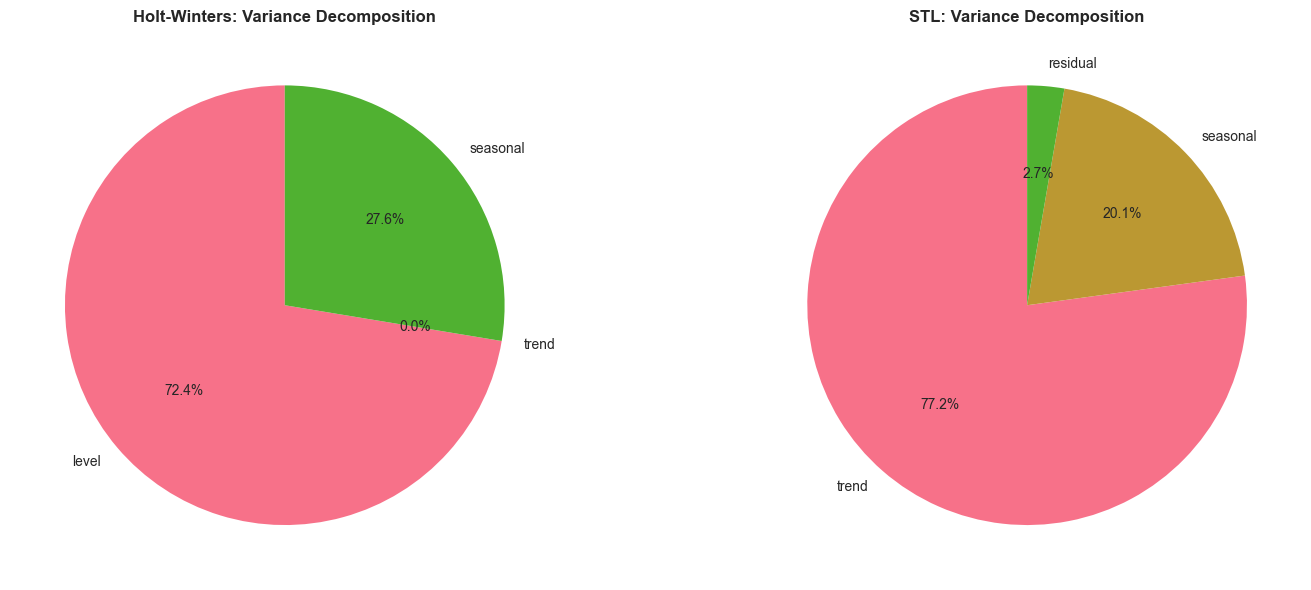

In [26]:
# Variance decomposition
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Holt-Winters variance
hw_var = components_hw.var()
hw_var_clean = hw_var.dropna()
axes[0].pie(hw_var_clean, labels=hw_var_clean.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Holt-Winters: Variance Decomposition', 
                  fontsize=12, fontweight='bold')

# STL variance
stl_var = components_stl.var()
axes[1].pie(stl_var, labels=stl_var.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('STL: Variance Decomposition', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Takeaways

### Exponential Smoothing (ETS)
1. **Simple ES**: Use for data with no trend or seasonality
2. **Holt's Method**: Adds trend component to Simple ES
3. **Holt-Winters**: Adds both trend and seasonality
4. **Smoothing Parameters**: 
   - α (alpha): Controls level smoothing
   - β (beta): Controls trend smoothing
   - γ (gamma): Controls seasonal smoothing
   - φ (phi): Damping parameter for trend
5. **Model Selection**: Use AIC/BIC (lower is better)

### STL Decomposition
1. **Flexibility**: Handles any type of seasonality
2. **Robustness**: Resistant to outliers when robust=True
3. **Multiple Seasonalities**: MSTL supports multiple periods
4. **Changing Patterns**: Seasonal component can evolve over time
5. **Strength Metrics**: Quantify importance of trend/seasonal components

### Best Practices
1. **Always visualize** your time series first
2. **Check stationarity** before modeling
3. **Split data** into train/test sets
4. **Compare multiple models** using consistent metrics
5. **Examine residuals** to validate model assumptions
6. **Consider computational cost** for large datasets
7. **Use domain knowledge** to guide model selection

### Model Selection Guide
- **Quick baseline**: Simple ES or Holt's method
- **Clear seasonality**: Holt-Winters
- **Complex patterns**: STL + ARIMA
- **Multiple seasonalities**: MSTL
- **Need interpretability**: ETS methods
- **Need flexibility**: STL/MSTL
- **Statistical inference**: ARIMA